In [1]:
import pandas as pd
import numpy as np
import os, zipfile
import matplotlib.pyplot as plt
import dask
from datetime import datetime
%matplotlib inline
%config InlineBackend.figure_format='retina'

`is_buyer_maker = True` $\rightarrow$ a buyer has taken the ask price $\rightarrow$ `trade_price = ask_price`

## Merge all df by symbol

In [2]:
done = True
symbols = ['ADAUSDT', 'BTCUSDT', 'BNBUSDT', 'DASHUSDT', 'ETHUSDT', 'LINKUSDT', 'LTCUSDT', 'NANOUSDT', 'THETAUSDT', 'XRPUSDT']

if not done : 
    for symbol in symbols:
        print(symbol)
        path = 'data.nosync/'+symbol
        dfs = []
        all_files = sorted(os.listdir(path))
        if '.DS_Store' in all_files:
            all_files.remove('.DS_Store')
        for file in all_files:
            print(file, end='\r')
            curr  = pd.read_hdf(path+'/'+file)
            dfs.append(curr)

        df = pd.concat(dfs)
        df.to_parquet(f'data.nosync/_all/{symbol}.pq')


## Full Data

#### Volume

In [6]:
symbol = 'THETAUSDT'
symb = symbol[:-4]

df = pd.read_parquet('data.nosync/_all/'+symbol+'.pq')
df = df.astype({'volume': 'float', 'price': 'float'})
df = df[df.is_trade_best_price==True]
df.drop(columns='is_trade_best_price', inplace=True)
df

,trade_id,price,volume,first_id,last_id,is_buyer_maker
timestamp,,,,,,
2019-07-18 00:00:03.984,361710,0.11229,448.5,408134,408134,False
2019-07-18 00:00:04.680,361711,0.11229,224.2,408135,408135,False
2019-07-18 00:00:05.072,361712,0.11229,179.4,408136,408136,False
2019-07-18 00:00:05.121,361713,0.11229,179.4,408137,408137,False
2019-07-18 00:00:15.339,361714,0.11200,0.9,408138,408138,True
...,...,...,...,...,...,...
2020-12-28 23:59:56.016,8099634,1.55583,204.1,8798961,8798961,False
2020-12-28 23:59:56.530,8099635,1.55669,7.0,8798962,8798962,False
2020-12-28 23:59:56.530,8099636,1.55777,135.0,8798963,8798963,False


In [113]:
df_group = df.groupby([df.index.hour, df.index.minute]).count()

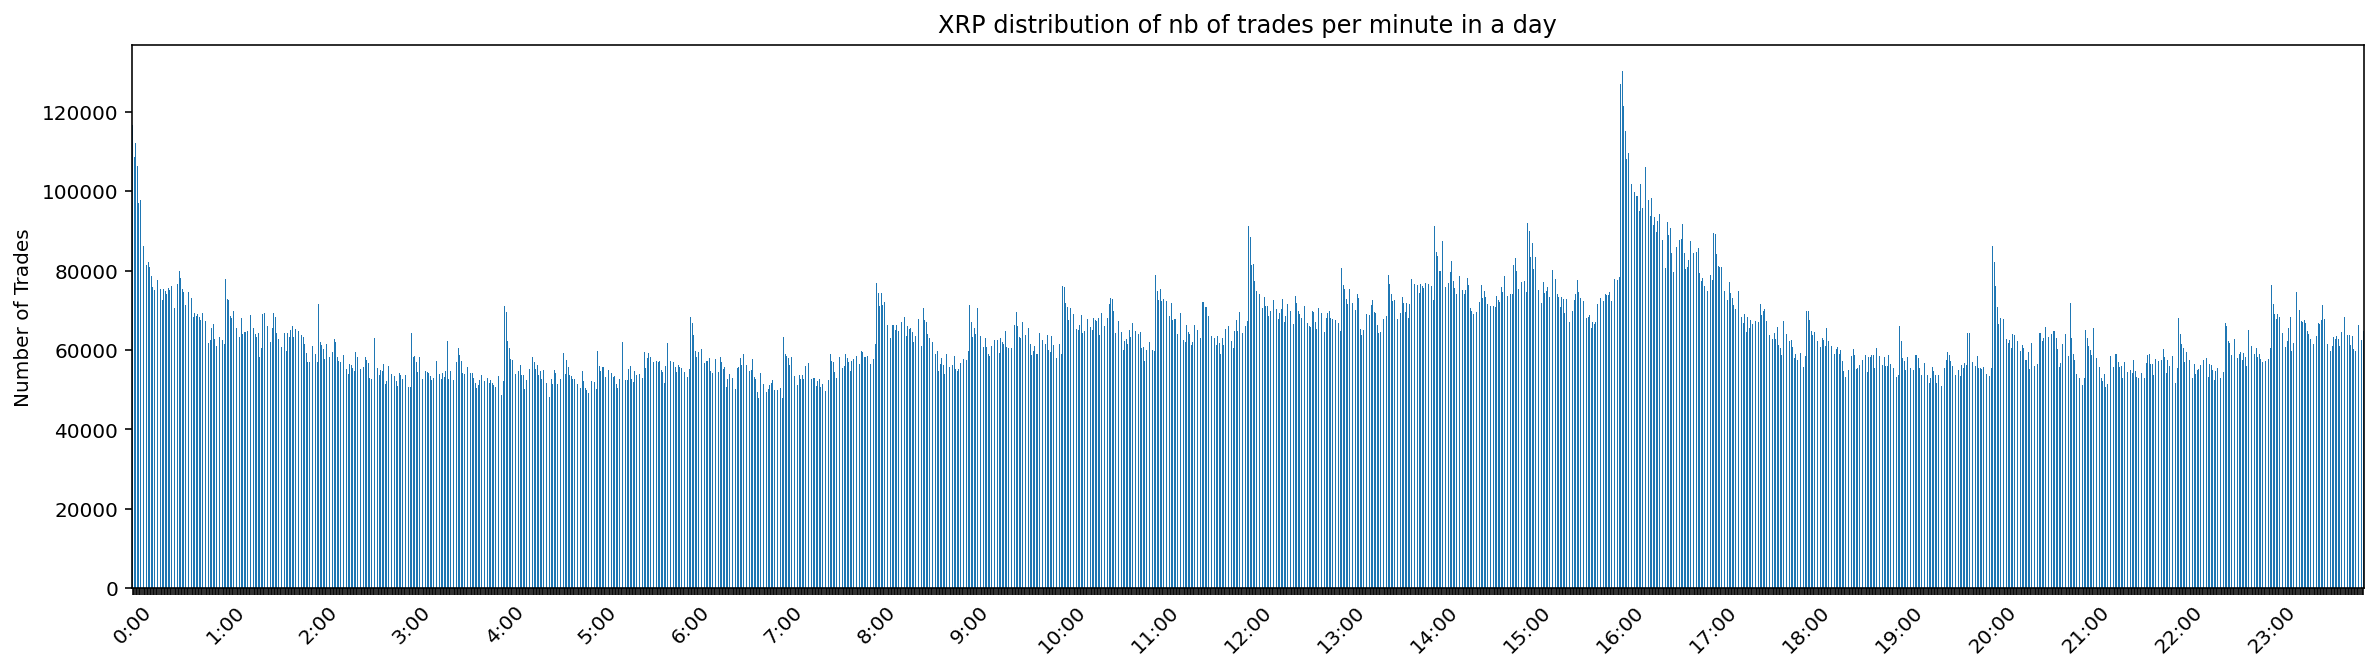

In [114]:
df_group['trade_id'].plot(kind='bar', figsize=(20, 5))
plt.xticks(np.arange(24*60), [str(i//60)+':00' if i%60==0 else '' for i in range(24*60)], rotation=45)
plt.ylabel('Number of Trades')
plt.xlabel('')
title = symb+' distribution of nb of trades per minute in a day'
plt.title(title)
plt.savefig('images/'+title+'.eps', format='eps')
plt.show()

In [115]:
df['usdt_volume']= df.price*df.volume
df_group = df.groupby([df.index.hour, df.index.minute])['usdt_volume'].sum()

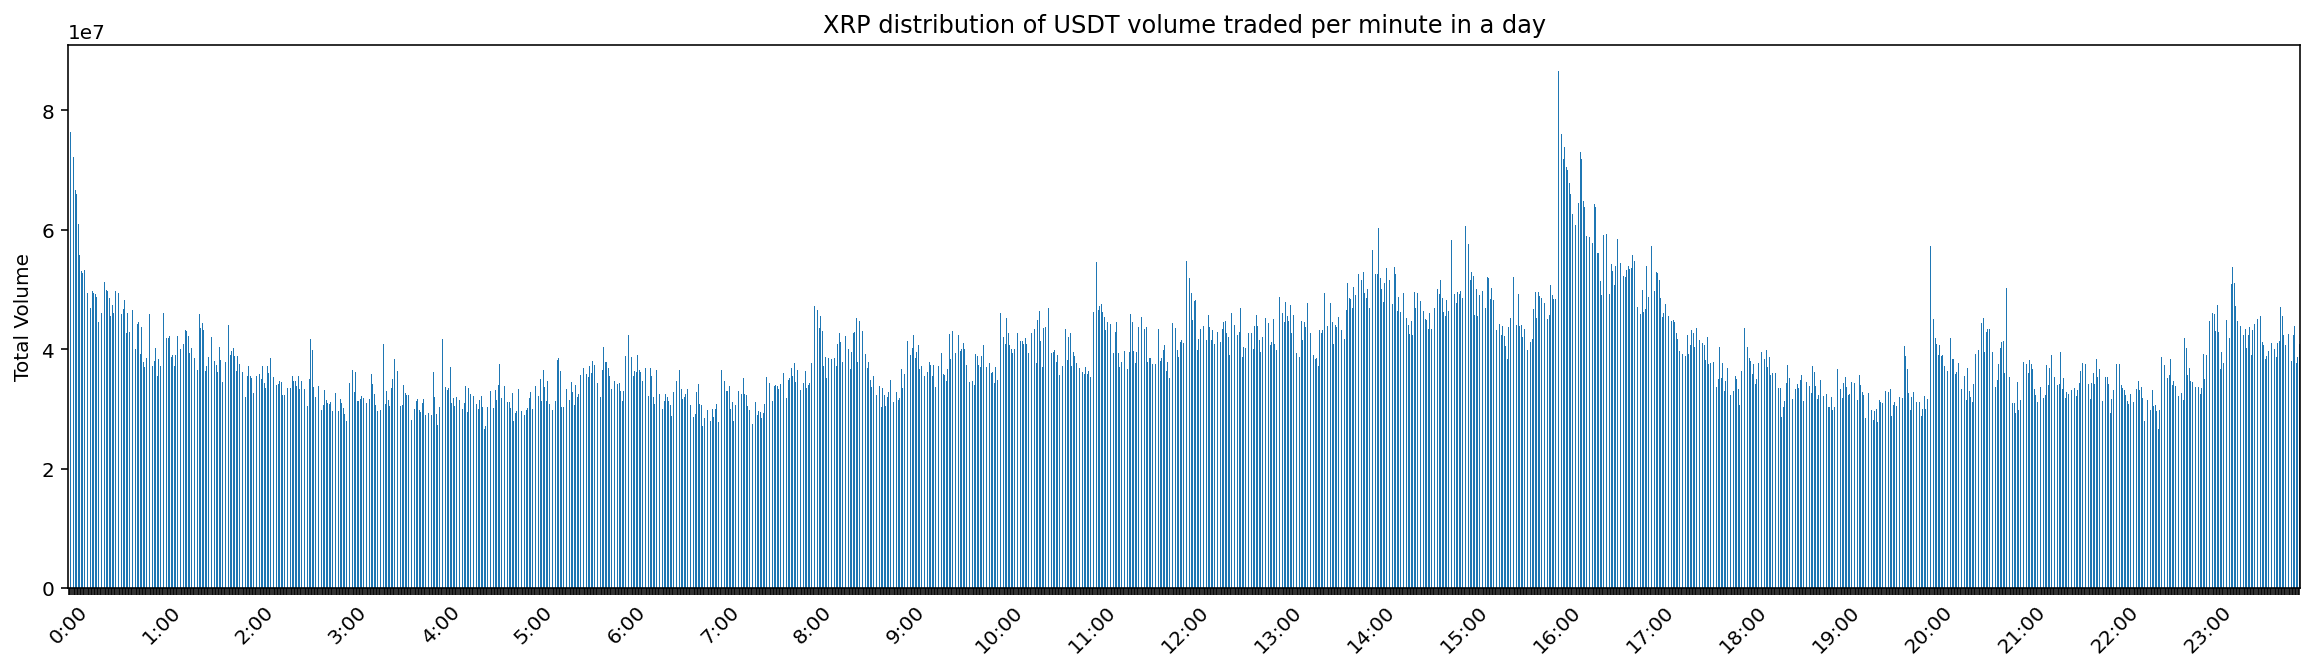

In [116]:
df_group.plot(kind='bar', figsize=(20, 5))
plt.xticks(np.arange(24*60), [str(i//60)+':00' if i%60==0 else '' for i in range(24*60)], rotation=45)
plt.ylabel('Total Volume')
plt.xlabel('')
title = symb+' distribution of USDT volume traded per minute in a day'
plt.title(title)
plt.savefig('images/'+title+'.eps', format='eps')
plt.show()

In [117]:
df_group = df.groupby(pd.Grouper(freq='1Min', origin=0, label='right')).sum()['usdt_volume']

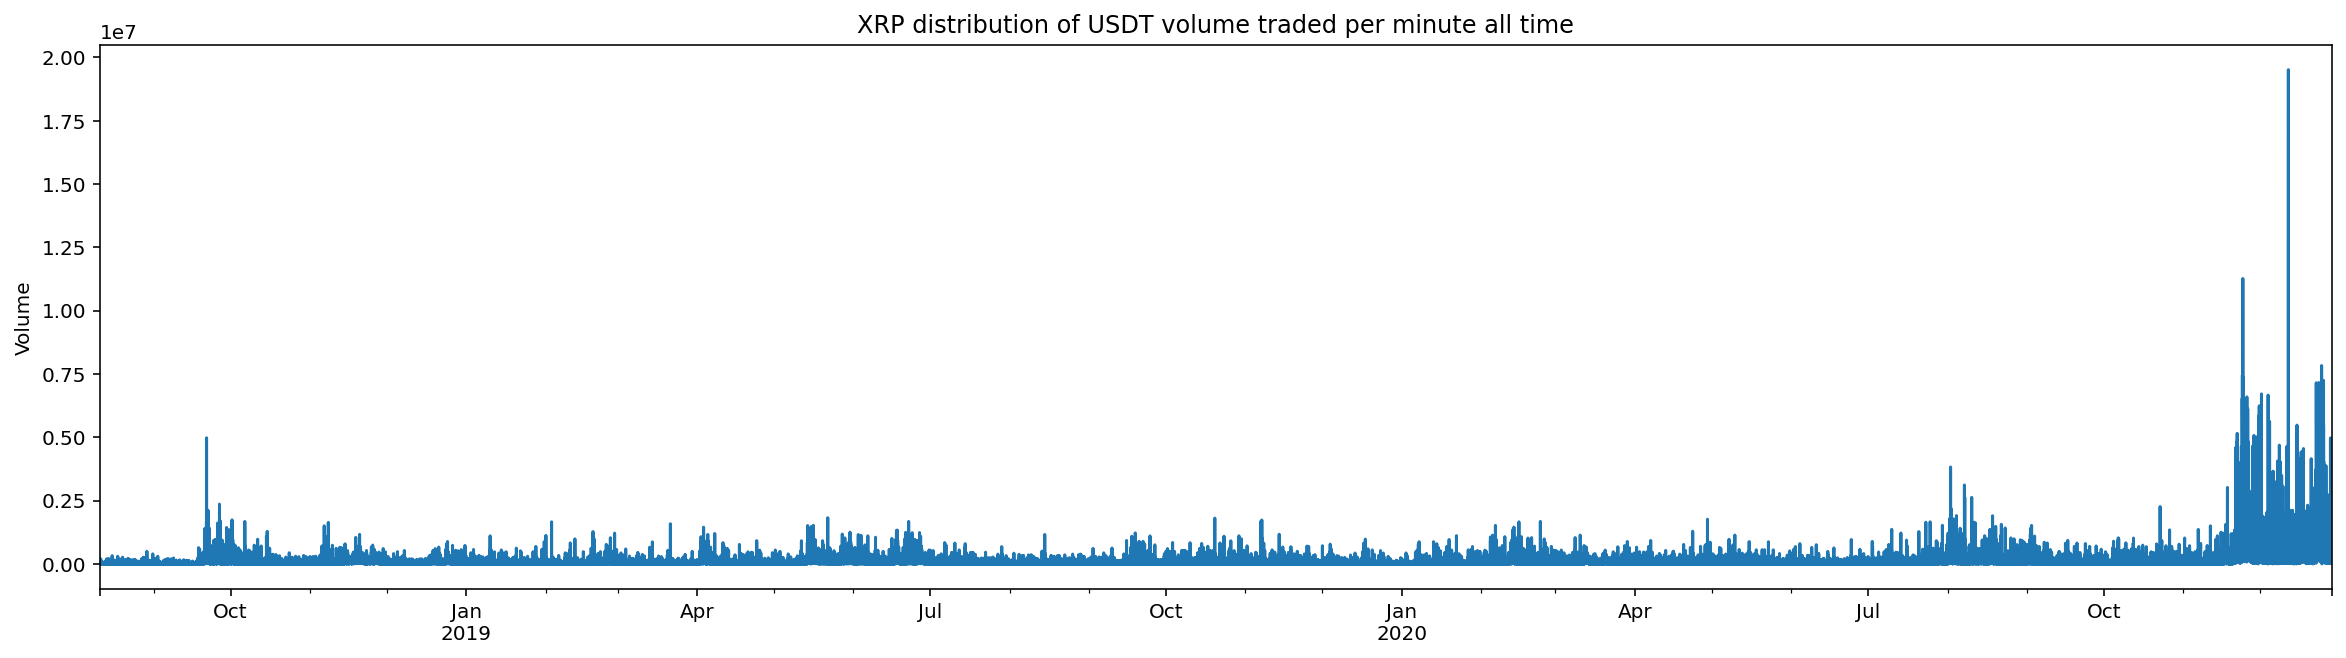

In [118]:
df_group.plot(figsize=(20, 5))
plt.ylabel('Volume')
plt.xlabel('')
title = symb+' distribution of USDT volume traded per minute all time'
plt.title(title)
plt.savefig('images/'+title+'.eps', format='eps')
plt.show()

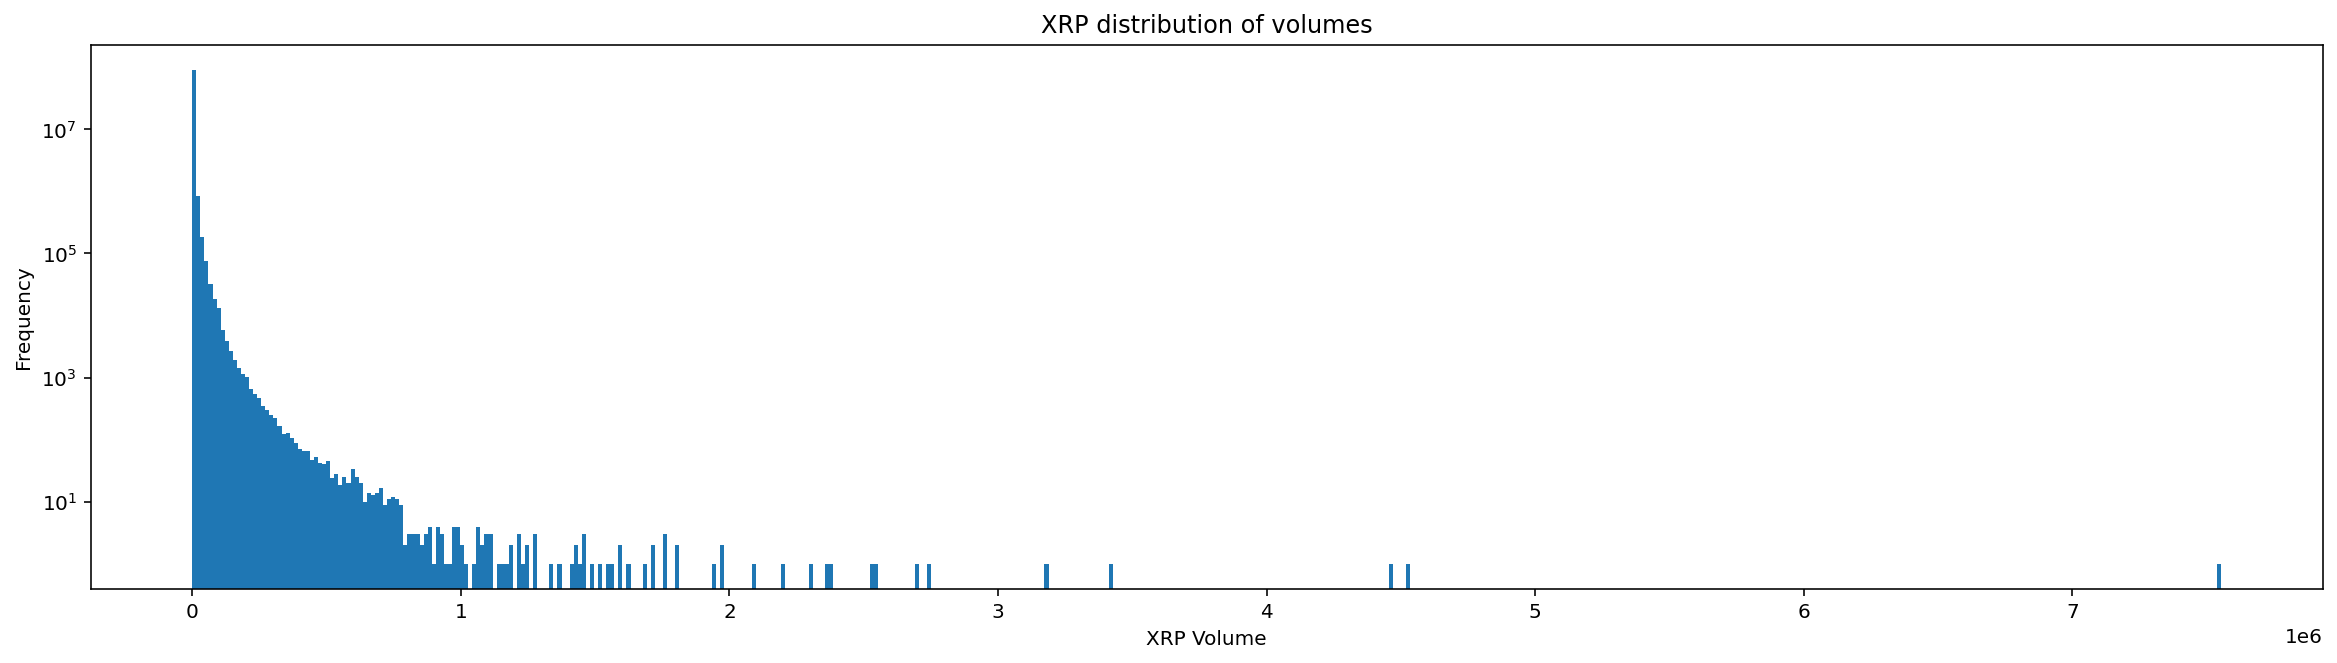

In [119]:
df['volume'].plot(kind='hist', bins=500, log=True, figsize=(20, 5))
plt.xlabel(symb+' Volume')
title = symb+' distribution of volumes'
plt.title(title)
plt.savefig('images/'+title+'.eps', format='eps')

plt.show()

## Aggregated data

In [8]:
df_group = df.groupby([pd.Grouper(freq='30s', origin=0, label='right'),
                             'is_buyer_maker']).agg({'trade_id': ['count'],
                                                     'price': ['min', 'max', 'mean'],
                                                     'volume':'sum'}).reset_index()
df_group.columns = df_group.columns.get_level_values(0)
df_group.index = df_group.timestamp
df_group.drop(columns='timestamp', inplace=True)
df_group.columns = ['is_buyer_maker','nb_trade','min_price','max_price','mid_price','volume_tot']
df_group['mid_price'] = df_group['mid_price'].groupby('timestamp').mean() #group mid_price

df_group.to_parquet(f'data.nosync/_aggreg/{symbol}.pq')
df_group

,is_buyer_maker,nb_trade,min_price,max_price,mid_price,volume_tot
timestamp,,,,,,
2019-07-18 00:00:30,False,23,0.11147,0.11229,0.111722,41967.7
2019-07-18 00:00:30,True,2,0.11158,0.11200,0.111722,352.6
2019-07-18 00:01:00,True,3,0.11147,0.11147,0.111470,8334.3
2019-07-18 00:02:00,False,2,0.11192,0.11192,0.111920,52.5
2019-07-18 00:03:00,False,1,0.11188,0.11188,0.111880,27.1
...,...,...,...,...,...,...
2020-12-28 23:59:00,True,18,1.54999,1.55400,1.552118,4542.4
2020-12-28 23:59:30,False,11,1.55026,1.55436,1.551572,5984.6
2020-12-28 23:59:30,True,3,1.55042,1.55111,1.551572,524.3


**Compression ratio** $ =\frac{\text{initial number of trades}}{\text{final nb of trades}}$

- ADAUSDT : $\frac{37223770}{3876151} = 9.603$
- BTCUSDT : $\frac{477050380}{6466922} = 73.768$
- BNBUSDT : $\frac{87110316}{5420005} = 16.072$
- DASHUSDT : $\frac{11440902}{1588643} = 7.202$
- ETHUSDT : $\frac{195293301}{6404237} = 30.494$
- LINKUSDT : $\frac{53669544}{2717785} = 19.748$
- LTCUSDT : $\frac{55619122}{4975254} = 11.18$
- NANOUSDT : $\frac{1853754}{535838} = 3.46$
- THETAUSDT : $\frac{7737929}{1015545} = 7.619$
- XRPUSDT : $\frac{92456490}{4744723} = 19.486$


**Time recorded:**

- ADAUSDT :   $\ \ $ 2018-07-25 $\rightarrow$ 2020-12-29
- BTCUSDT :   $\ \ \ $2017-11-24 $\rightarrow$ 2020-12-29
- BNBUSDT :   $\ \ \ $2018-02-13 $\rightarrow$ 2020-12-29
- DASHUSDT :  $\ $2019-07-05 $\rightarrow$ 2020-12-29
- ETHUSDT :   $\ \ \ \ $2017-11-24  $\rightarrow$ 2020-12-29
- LINKUSDT :  $\ \ \ $2019-04-25 $\rightarrow$ 2020-12-29
- LTCUSDT :   $\ \ \ \ \ $2018-03-22 $\rightarrow$ 2020-12-29
- NANOUSDT :  $\ \ $2019-07-11 $\rightarrow$ 2020-12-29
- THETAUSDT : $\ $ 2019-07-18 $\rightarrow$ 2020-12-29
- XRPUSDT :   $\ \ \ \ \ \ $2018-08-11 $\rightarrow$ 2020-12-29


#### Load the aggregated data

In [16]:
symbols = ['ADAUSDT', 'BTCUSDT', 'BNBUSDT', 'DASHUSDT', 'ETHUSDT', 'LINKUSDT', 'LTCUSDT', 'NANOUSDT', 'THETAUSDT', 'XRPUSDT']
symbs, dfs = [], []

for symbol in symbols:
    symbs.append(symbol[:-4])
    dfs.append(pd.read_parquet('data.nosync/_aggreg/'+symbol+'.pq'))

#### Price

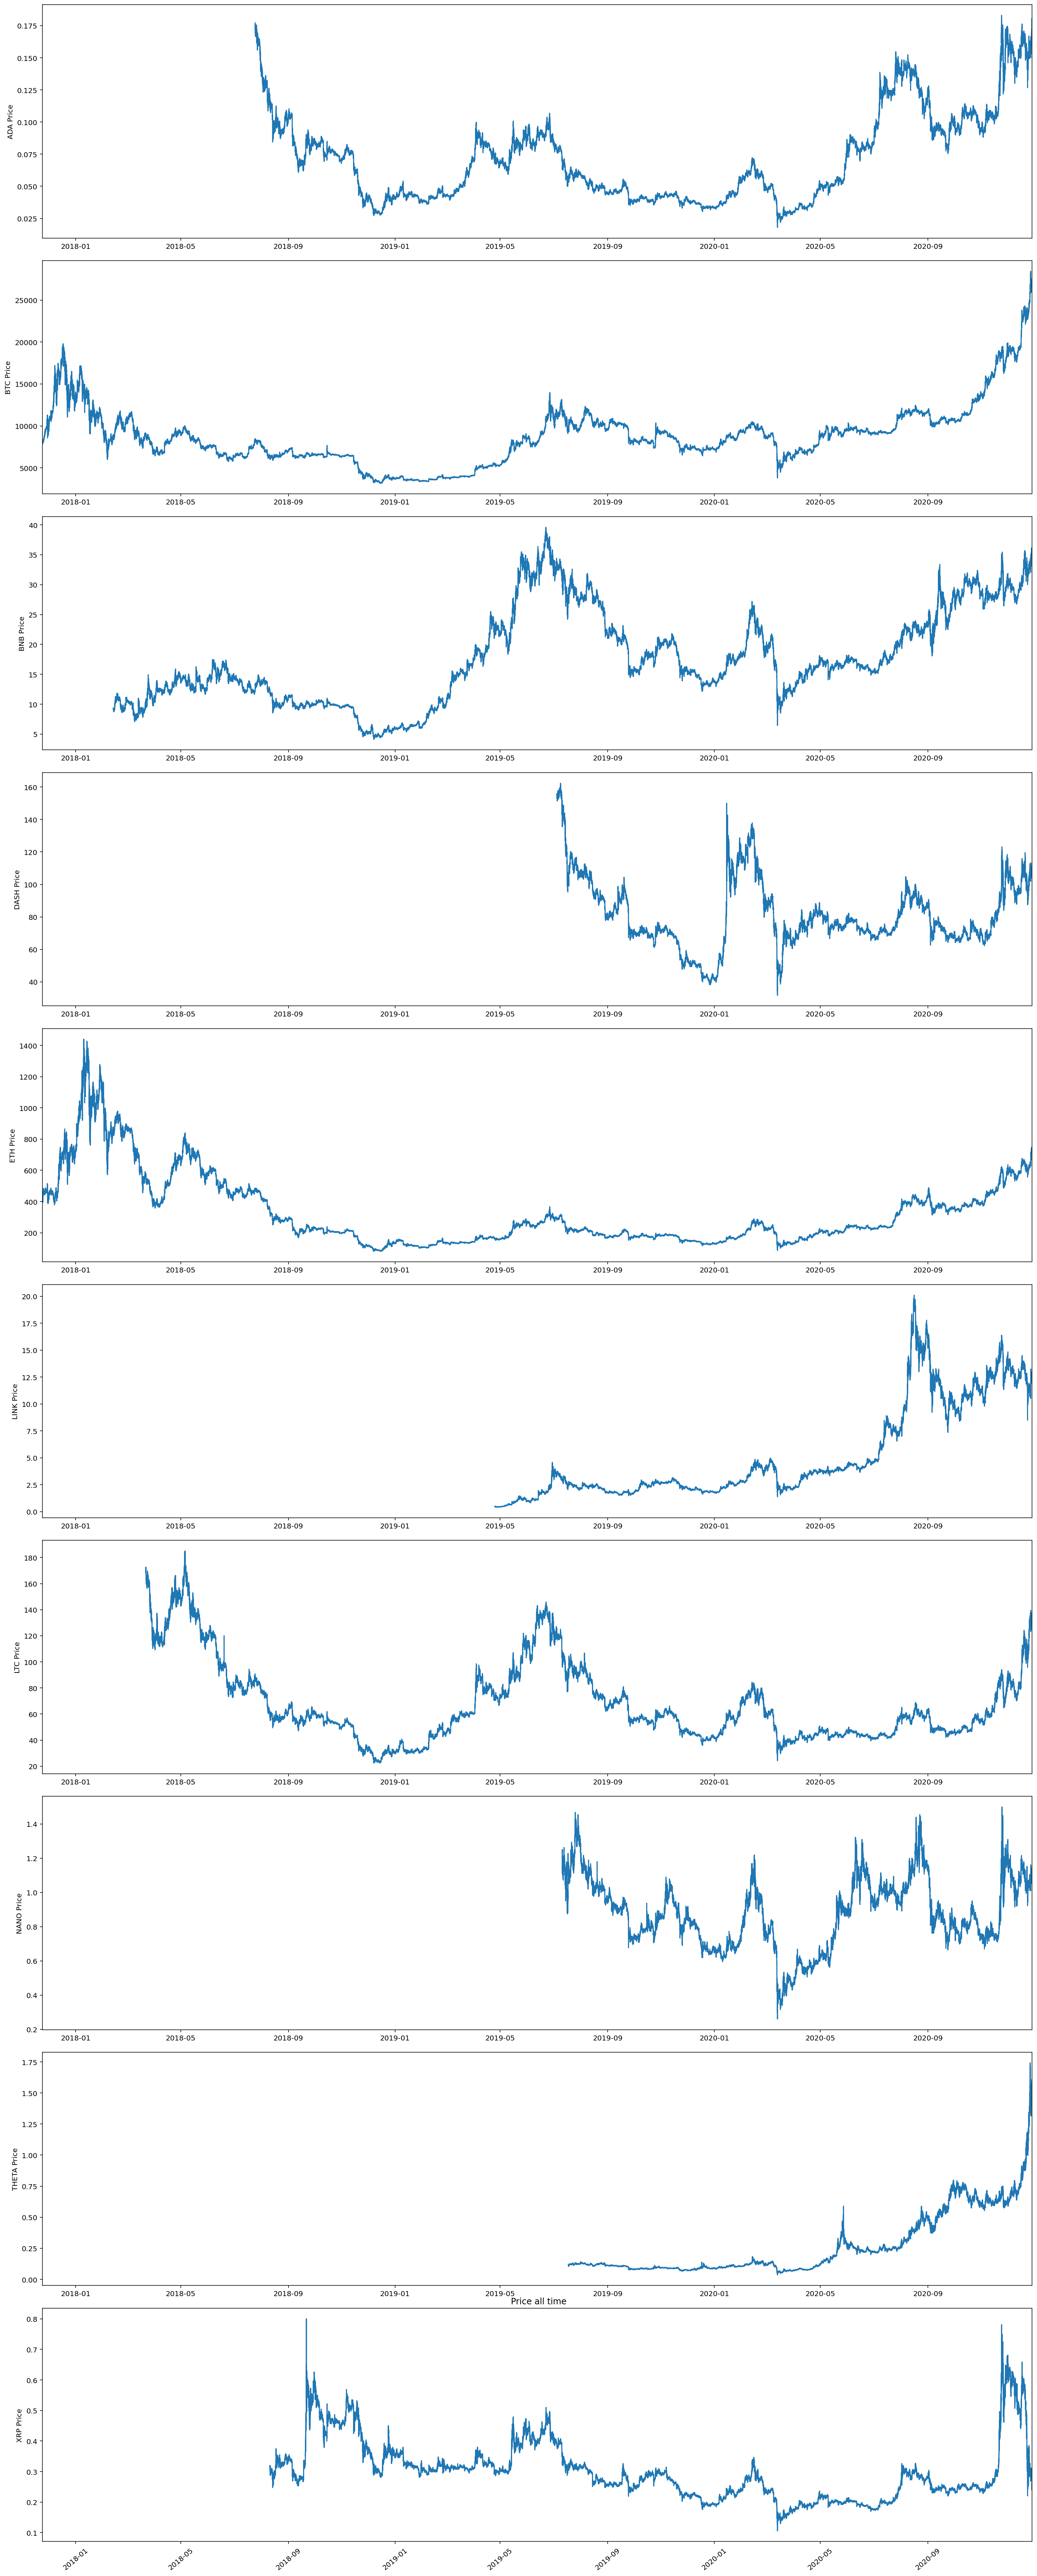

In [4]:
fig, axs = plt.subplots(nrows=10, ncols=1, figsize=(20, 50))
fig.tight_layout()

for i in range(len(axs)):
    axs[i].plot(dfs[i].index, dfs[i]['max_price'])
    axs[i].set_ylabel(symbs[i]+' Price')
    plt.xticks(rotation=40)
    axs[i].set_xlim(datetime(2017,11,24), dfs[i].index[-1])
title = ' Price all time'
plt.title(title)
plt.savefig('images/'+title+'.eps', format='eps')
plt.show()

#### Spread

In [17]:
# Compute the spread for each asset by taking the spread between the buyer trades' mid-price & seller trades' mid-price
for i in range(len(dfs)):
    dfs[i] = dfs[i]['mid_price'].groupby('timestamp').apply(lambda x : x[0] - x[-1] if x[0]!=x[-1] else None).ffill()

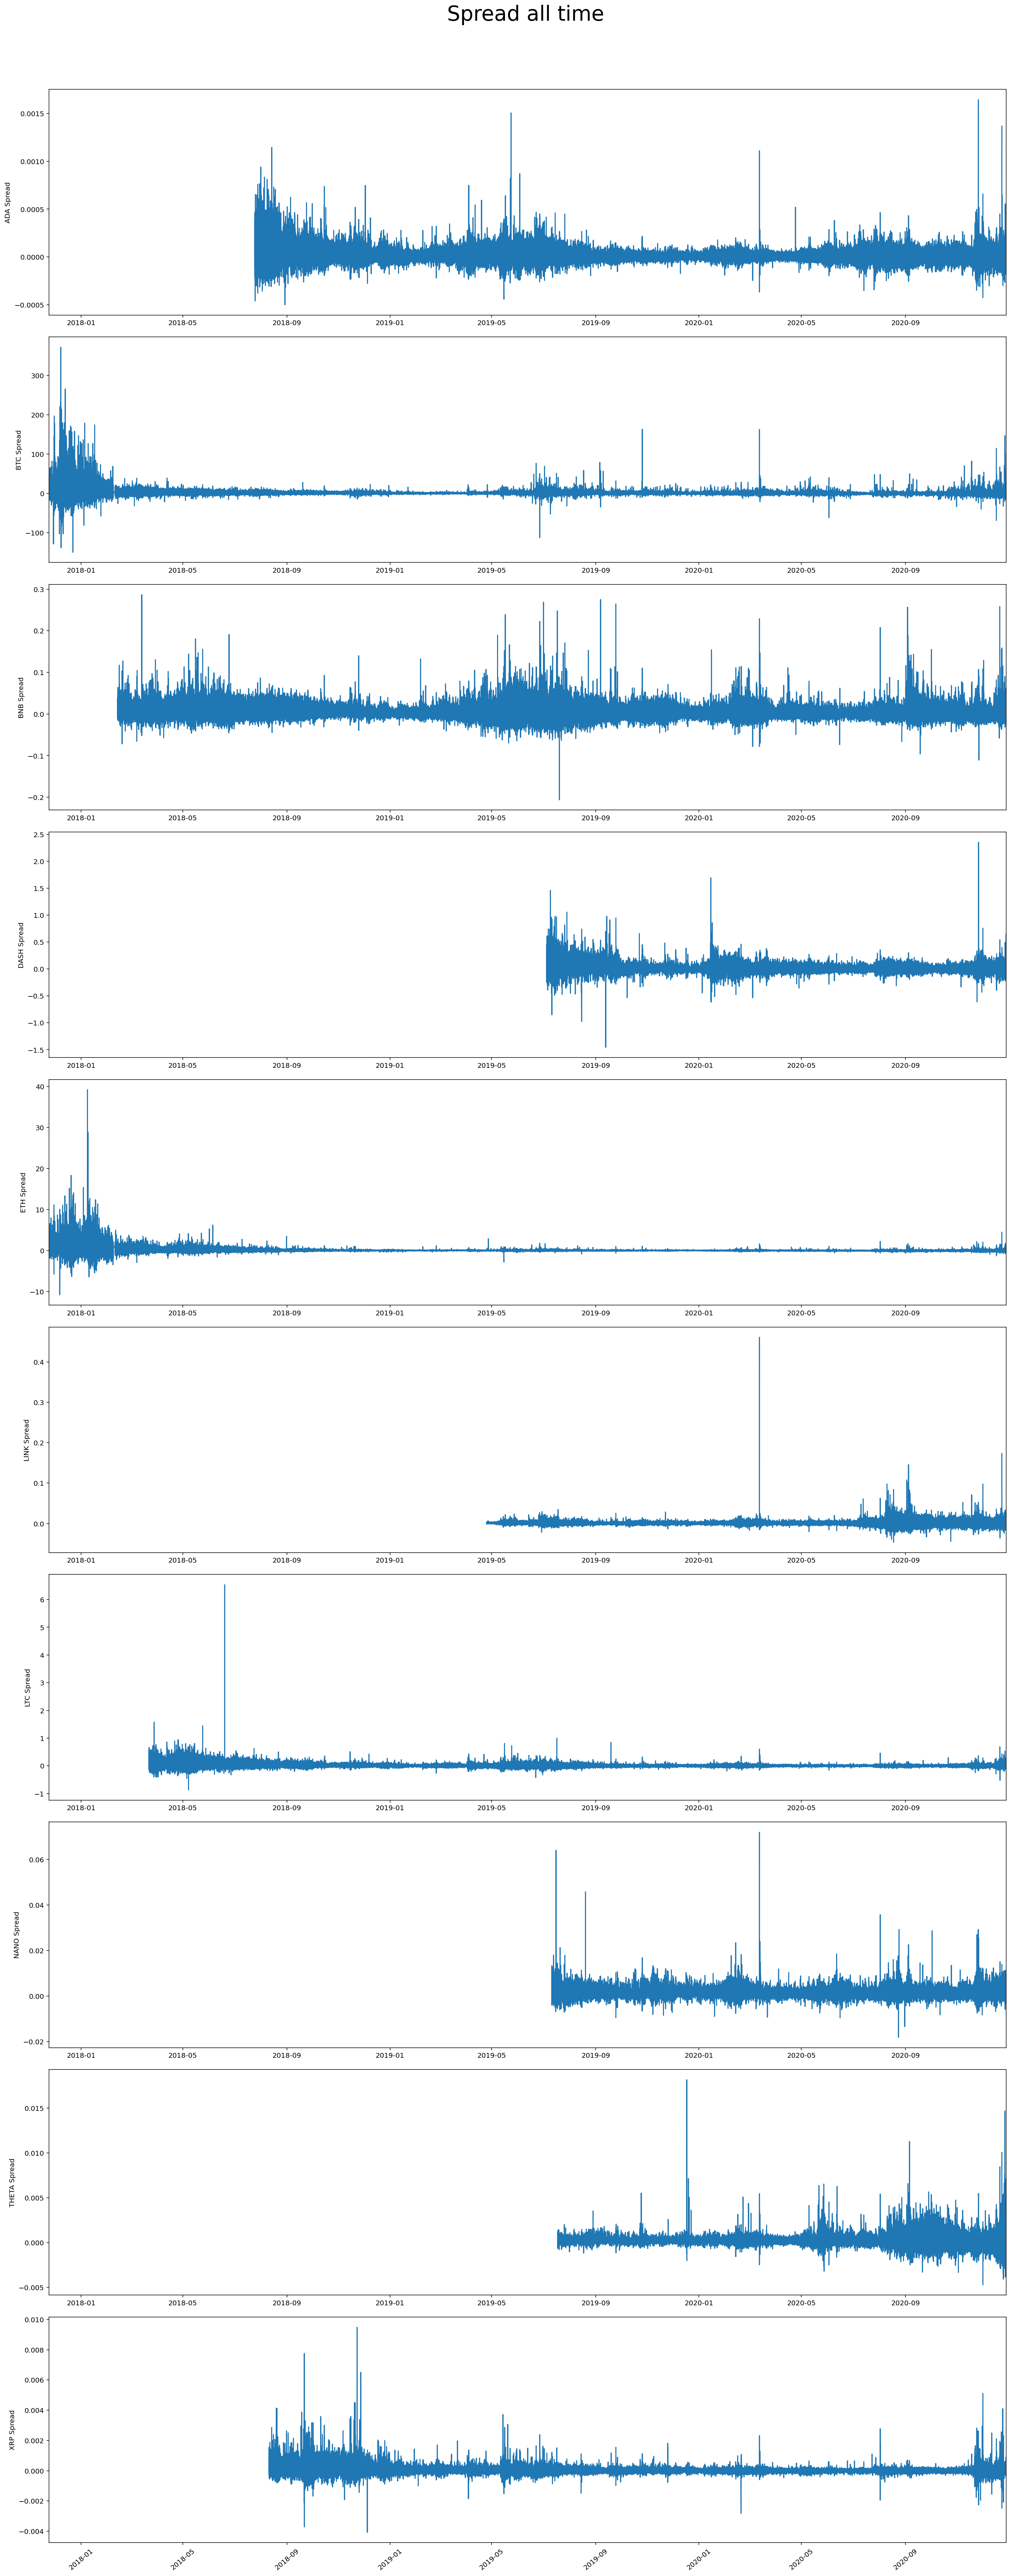

In [22]:
fig, axs = plt.subplots(nrows=10, ncols=1, figsize=(20, 50))
fig.tight_layout()

for i in range(len(axs)):
    axs[i].plot(dfs[i].index, dfs[i].values)
    axs[i].set_ylabel(symbs[i]+' Spread')
    plt.xticks(rotation=40)
    axs[i].set_xlim(datetime(2017,11,24), dfs[i].index[-1])
title = ' Spread all time'
plt.suptitle(title, fontsize=30, y=1.03)
plt.savefig('images/'+title+'.png', format='png')
plt.show()

We can see that sometimes the spread is negative. This is due to the fact that we have estimated the ask and bid price of assets by taking the average of buyer-initiated trades and seller-initiated trades respectively. It happens that sometimes, over the chosen time interval (30s), the average trade-price of buyer-initiated trades is smaller than the one corresponding to the seller-initiated trades. 

To counter this problem, we can compute the spread for each cryptocurrency by taking the spread between the min price of the buyer trades & max price of seller trades

In [23]:
# Reload data into dfs
dfs = []
for symbol in symbols:
    symbs.append(symbol[:-4])
    dfs.append(pd.read_parquet('data.nosync/_aggreg/'+symbol+'.pq'))

In [24]:
# Compute the spread for each asset by taking the spread between the min of buyer trades & max of seller trades
for i in range(len(dfs)):
    dfs[i] = dfs[i][['min_price','max_price']].groupby('timestamp').apply(lambda x : x.iloc[0].max_price - x.iloc[-1].min_price if x.iloc[0].max_price!=x.iloc[-1].max_price else None).ffill()

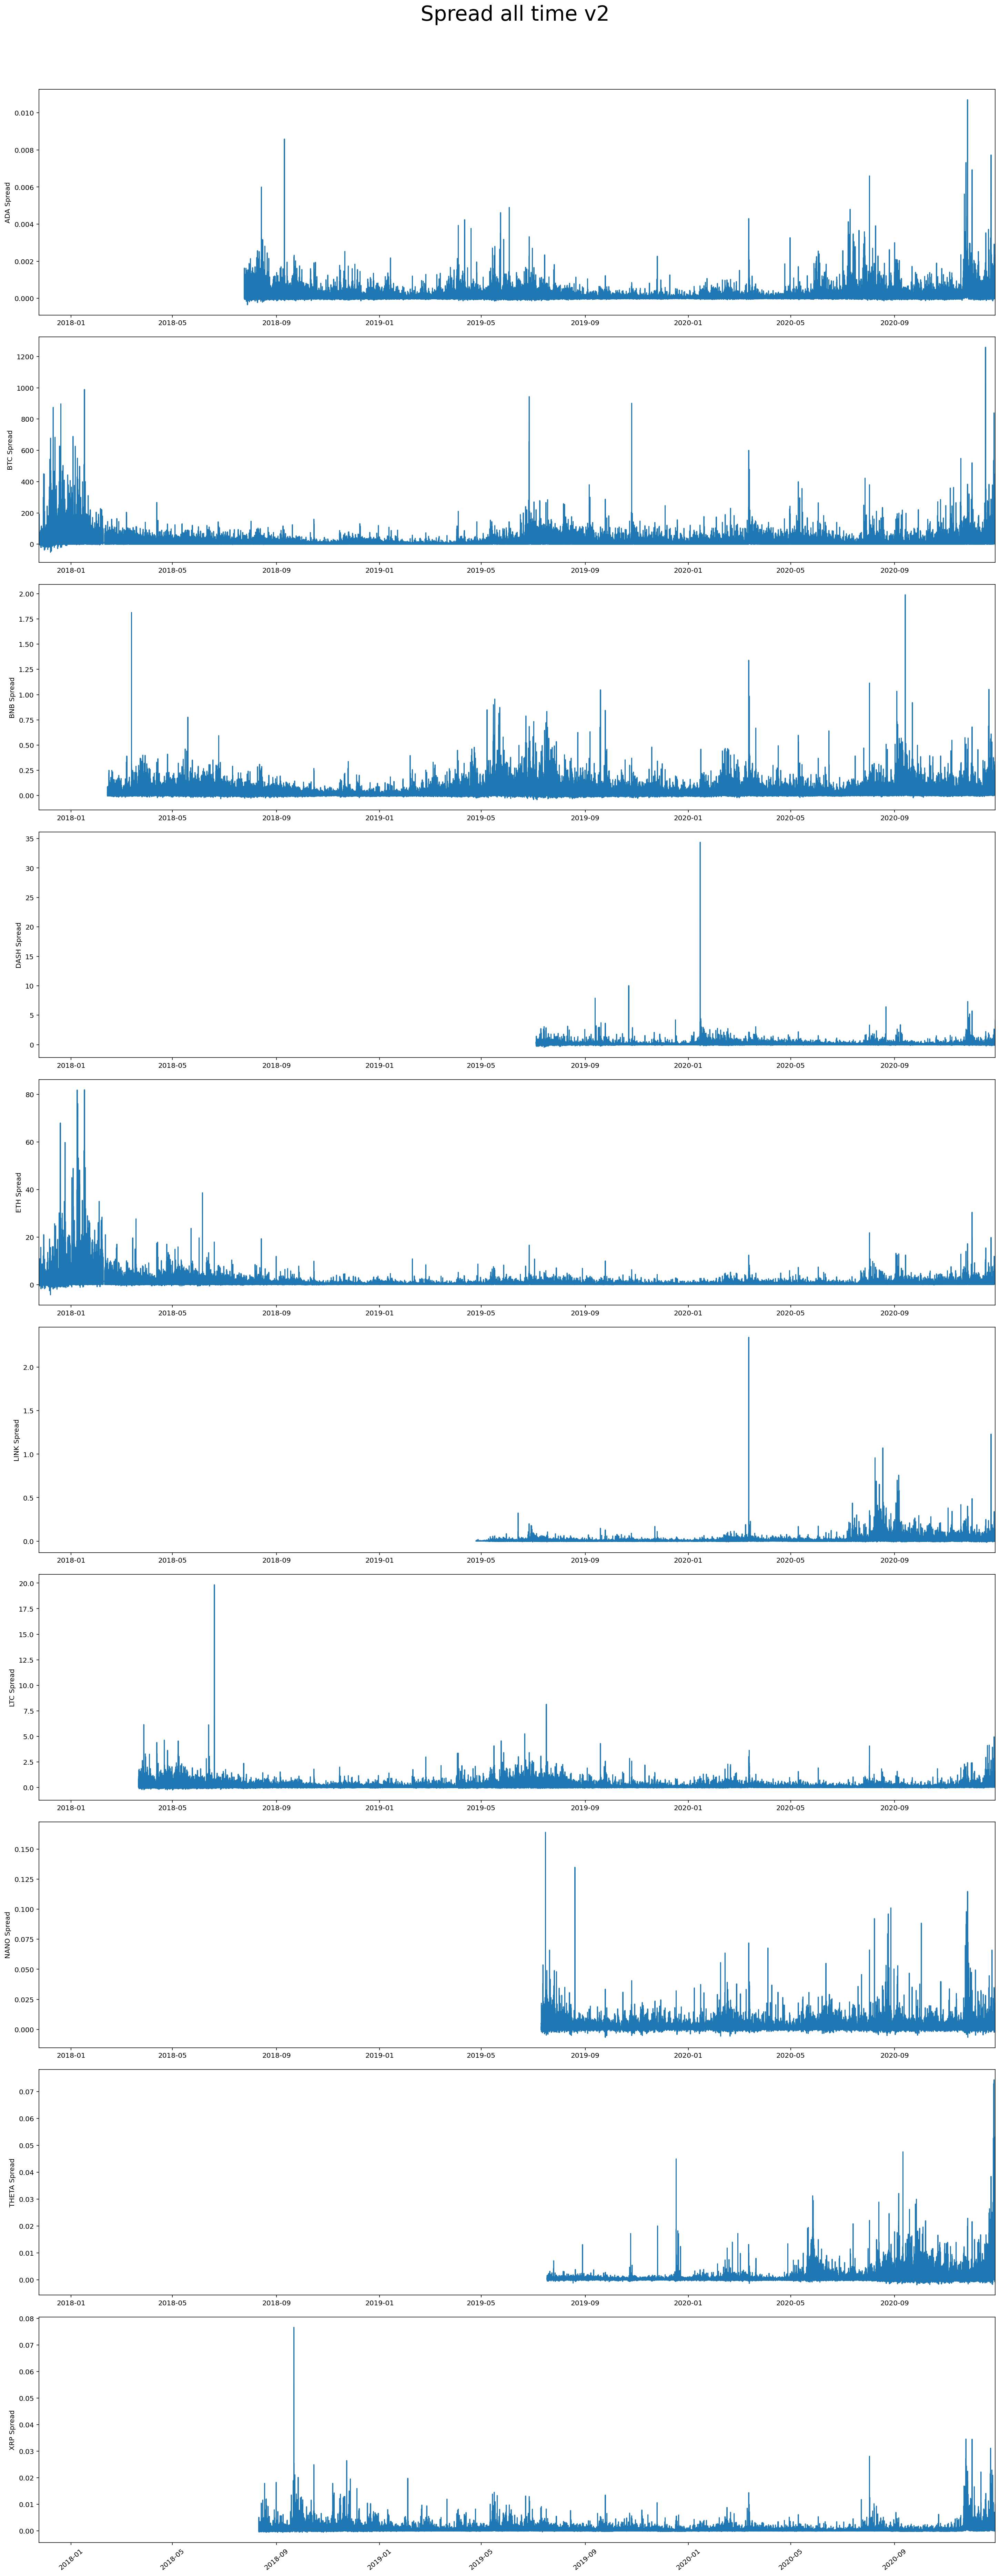

In [25]:
fig, axs = plt.subplots(nrows=10, ncols=1, figsize=(20, 50))
fig.tight_layout()

for i in range(len(axs)):
    axs[i].plot(dfs[i].index, dfs[i].values)
    axs[i].set_ylabel(symbs[i]+' Spread')
    plt.xticks(rotation=40)
    axs[i].set_xlim(datetime(2017,11,24), dfs[i].index[-1])
title = ' Spread all time v2'
plt.suptitle(title, fontsize=30, y=1.03)
plt.savefig('images/'+title+'.png', format='png')
plt.show()